## Classifying mangrove damage and recover due to tropical cyclones
- based on Emmas_code_TC_mangroves.py
- need to use geotiffs (30m EPSG 3577) in google drive for the windfield data input

In [1]:
# need to change so it reprojects in the nb not externally
# https://docs.dea.ga.gov.au/notebooks/Frequently_used_code/Reprojecting_data.html

# commandline used at the moment for reprojecting
# gdalwarp -t_srs EPSG:3577 -tr 30.0 30.0 -r near -of GTiff Yasi.tif Yasi_30m_EPSG3577.tif

In [2]:
import datacube
from datacube.model import Measurement
import numpy as np
import xarray as xr
from os import path
from datacube.drivers.netcdf import write_dataset_to_netcdf
from datacube.utils.geometry import CRS
import pandas as pd
import os
from  datacube import Datacube
from datacube.utils import geometry
import pickle
import sys
import rioxarray
dc = datacube.Datacube(app="cyclone mangroves")

from datacube.testutils.io import rio_slurp_xarray

from Cyclone_damage_funcs import *

### fill in data (doing one cyclone at a time for the moment)

In [3]:
cyclone_name = 'Yasi'
cyclone_time = 2011

# cyclone_name = 'Larry'
# cyclone_time = 2006

# cyclone_name = 'Ita'
# cyclone_time = 2014

# cyclone_name = 'Marcia'
# cyclone_time = 2015

# cyclone_name = 'Nathan_Landfall1'
# cyclone_time = 2015


### load in geotiff

In [4]:
geotiff_path = './FINALlocalWind/'+cyclone_name+'_30m_EPSG3577.tif'
# Open into an xarray.DataArray
geotiff_da = rioxarray.open_rasterio(geotiff_path)
# change -9999 to 0 #### not sure this needs to be done, -9999 should be considered 'not cyclone'?
geotiff_da = xr.where(geotiff_da == -9999, 0, geotiff_da.values)
# Covert our xarray.DataArray into a xarray.Dataset
geotiff_ds = geotiff_da.to_dataset('band')
# Rename the variable to a more useful name
dataset = geotiff_ds.rename({1: 'wind_speed'})

### rework to get geotiff as identical dc.load for mangroves

In [5]:
# get extent of cyclone dataset
geobox = dataset.extent
# get the cyclone start time
start_time = cyclone_time

# get time of cyclone
time_of_cyclone = (str(start_time) + '-01-01', str(start_time) + '-12-31')

# find datasets for mangrove canopy cover at cyclone time
time_of_cyclone_datasets = dc.find_datasets(product = 'ga_ls_mangrove_cover_cyear_3',time=time_of_cyclone, geopolygon=geobox)

# at time of cyclone mangrove canopy cover datasets, group by time
time_of_cyclone_datasets = dc.group_datasets(time_of_cyclone_datasets, group_by='time')

# get geometry box from geotiff
full_box = geometry.GeoBox.from_geopolygon(geobox, resolution=(30, -30))

# measurements for mangrove canopy cover
measurement = [Measurement(name='canopy_cover_class', dtype='int16', nodata=-1, units='1')]

# load mangrove canopy cover at time of cyclone
time_of_cyclone_data = dc.load_data(time_of_cyclone_datasets, geobox = full_box, measurements=measurement)

# load in geotiff again but with identical extent from dc.load mangroves
cyclone_da = rio_slurp_xarray(geotiff_path, gbox=time_of_cyclone_data.geobox)
# change -9999 to 0 #### not sure this needs to be done, -9999 should be considered 'not cyclone'?
# cyclone_da = xr.where(cyclone_da == -9999, 0, cyclone_da.values)
# add time dimension
cyclone_da_time = cyclone_da.expand_dims(dim={"time": time_of_cyclone_data.time})
# Covert our xarray.DataArray into a xarray.Dataset
cyclone_ds = cyclone_da_time.to_dataset(name="wind_speed")

# copy over attributes
cyclone_ds.attrs['grid_mapping'] = time_of_cyclone_data.attrs['grid_mapping']
cyclone_ds.attrs['crs'] = time_of_cyclone_data.attrs['crs']


### load mangrove data before and after cyclone (on extent of geotiff)

In [6]:
# get time query before cyclone
time_before_cyclone = (str(start_time - 1) + '-01-01', str(start_time - 1) + '-12-31')
# get time query after cyclone
time_after_cyclone = (str(start_time) + '-01-01', '2021-12-31')

# find all datasets for mangrove canopy cover before cyclone
bc_datasets = dc.find_datasets(product = 'ga_ls_mangrove_cover_cyear_3',time=time_before_cyclone, geopolygon=geobox)

In [7]:
# loop through extents for the different categories
cyclone_extent = {}
k = 0
for d in bc_datasets:
    cyclone_extent[k] = d.extent
    k += 1

In [8]:
# before cyclone mangrove canopy cover datasets, group by time
bc_datasets = dc.group_datasets(bc_datasets, group_by='time')
# find all datasets for mangrove canopy cover after cyclone
ac_datasets = dc.find_datasets(product = 'ga_ls_mangrove_cover_cyear_3',time=time_after_cyclone, geopolygon=geobox)
# after cyclone mangrove canopy cover datasets, group by time
ac_datasets = dc.group_datasets(ac_datasets, group_by='time')

In [9]:
# set up empty variables
wind_cat_full = None
all_wind_cat_full = None

for key, value in cyclone_extent.items():
    # get polygon extent of cyclone
    loading_polygon = value.intersection(geobox.to_crs(value.crs))
    # get bounding box of polygon with 30m res
    loading_box = geometry.GeoBox.from_geopolygon(loading_polygon, resolution=(30, -30))
    # run the function damage_level_by_geo
    wind_cat, all_wind_cat = damage_level_by_geo('./', cyclone_name, 
                                             cyclone_ds, bc_datasets, ac_datasets, 
                                             loading_box, dump=True)

    if wind_cat_full is None:
        wind_cat_full = wind_cat
        all_wind_cat_full = all_wind_cat
    else:
        wind_cat_full += wind_cat
        all_wind_cat_full += all_wind_cat
    print(wind_cat_full)
    print(all_wind_cat_full)

         0       1       2       3       4
C1     0.0     0.0     0.0     0.0     0.0
C2     0.0     0.0     0.0     0.0     0.0
C3  6.0282  3.0888  0.1296  0.0423  0.0054
C4     0.0     0.0     0.0     0.0     0.0
C5     0.0     0.0     0.0     0.0     0.0
         1       2       3       4       5
C1     0.0     0.0     0.0     0.0     0.0
C2     0.0     0.0     0.0     0.0     0.0
C3  4.1805  0.4365  0.1674  0.0081  0.0027
C4     0.0     0.0     0.0     0.0     0.0
C5     0.0     0.0     0.0     0.0     0.0
         0       1       2       3       4
C1     0.0     0.0     0.0     0.0     0.0
C2     0.0     0.0     0.0     0.0     0.0
C3  6.0282  3.0888  0.1296  0.0423  0.0054
C4     0.0     0.0     0.0     0.0     0.0
C5     0.0     0.0     0.0     0.0     0.0
         1       2       3       4       5
C1     0.0     0.0     0.0     0.0     0.0
C2     0.0     0.0     0.0     0.0     0.0
C3  4.1805  0.4365  0.1674  0.0081  0.0027
C4     0.0     0.0     0.0     0.0     0.0
C5     0.0 

In [10]:
with open('./Pickle_damage_results_collection3/'+cyclone_name+'_tally.pkl', 'wb') as f:
    pickle.dump((wind_cat_full, all_wind_cat_full), f)

In [11]:
with open('./Pickle_damage_results_collection3/'+cyclone_name+'_tally.pkl', 'rb') as f:
    wind_cat_full, all_wind_cat_full = pickle.load(f)

In [12]:
with open('./Pickle_damage_results_old/'+cyclone_name+'_tally.pkl', 'rb') as f:
    wind_cat_full_olddata, all_wind_cat_full_olddata = pickle.load(f)

In [13]:
# C1 - C5: category of cyclone windspeeed
# 0 = no change (km2)
# 1 = minor reduction
# 2 = major reduction
# 3 = loss of woodland
# 4 = loss of forest
wind_cat_full

,0,1,2,3,4
C1,0.0,0.0,0.0,0.0,0.0
C2,4.3227,0.8541,0.0009,0.0162,0.0297
C3,61.8381,35.2728,0.8676,0.1746,0.504
C4,86.571,131.4747,30.5919,0.5229,2.0907
C5,0.7587,2.9826,3.5667,0.0666,1.0152


In [14]:
wind_cat_full_olddata

,0,1,2,3,4
C1,6.00875,1.560625,0.006875,0.035,0.0375
C2,4.735625,1.01375,0.00125,0.005,0.031875
C3,64.60875,33.115,0.904375,0.216875,0.601875
C4,80.4475,138.90125,32.875625,0.30875,3.6925
C5,0.443125,2.80375,3.455,0.033125,1.36375


In [15]:
# C1 - C5: category of cyclone windspeeed
# 0 = no change (km2)
# 1 = temporary reduction
# 2 = persistent reduction
# 3 = temporary loss
# 4 = persistent loss
# 5 = total loss
all_wind_cat_full

,1,2,3,4,5
C1,0.0,0.0,0.0,0.0,0.0
C2,1.8081,0.0,0.2277,0.0081,0.0117
C3,49.113,1.7424,2.079,0.0522,0.1026
C4,168.3702,8.9253,8.0955,0.261,0.2457
C5,4.8573,1.3536,1.4796,0.0189,0.0387


In [16]:
all_wind_cat_full_olddata

,1,2,3,4,5
C1,2.724375,0.386875,0.18,0.005,0.0
C2,1.800625,0.00375,0.14125,0.003125,0.01125
C3,41.22125,5.278125,2.110625,0.0875,0.1225
C4,152.86375,26.195625,9.135625,0.13625,0.660625
C5,3.060625,2.9075,1.489375,0.006875,0.214375


### plotting impact of cyclone

Text(0.5, 0, 'Wind speed categories')

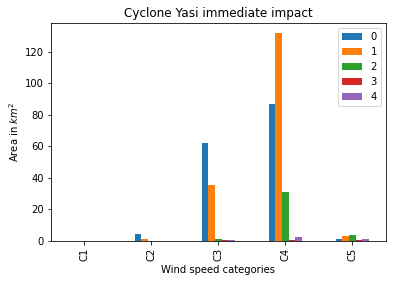

In [17]:
figure_a = wind_cat_full.astype('float').plot(kind='bar', title='Cyclone '+ cyclone_name +' immediate impact')
figure_a.set_ylabel('Area in $km^2$')
figure_a.set_xlabel('Wind speed categories')

Text(0.5, 0, 'Wind speed categories')

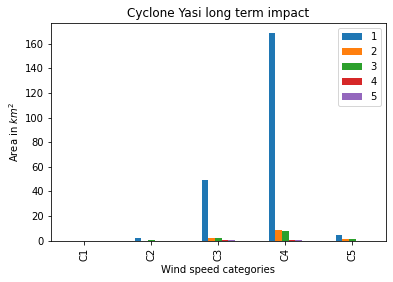

In [18]:
figure_a = all_wind_cat_full.astype('float').plot(kind='bar', title='Cyclone '+ cyclone_name +' long term impact')
figure_a.set_ylabel('Area in $km^2$')
figure_a.set_xlabel('Wind speed categories')